#Import Libraries

In [ ]:
import os
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Image Paths, Directories

In [ ]:
# Set the image paths
images_dir = './Water Bodies Dataset/Images'
masks_dir = './Water Bodies Dataset/Masks'

dirname, _, filenames = next(os.walk(images_dir))


In [ ]:
@tf.function
def load_img_with_mask(image_path, images_dir : str = "Images", masks_dir : str = "Masks",
                       images_extension : str = "jpg", masks_extension: str = "jpg") -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    
    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels = 3, expand_animations = False)
    
    return (image, mask)


In [ ]:
n = 3
examples = [load_img_with_mask(   os.path.join(images_dir, filenames[i]) ) for i in range(n)  ]

fig, axs = plt.subplots(n, 2, figsize = (14, 7*n), constrained_layout = True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")

# Image Preprocessing

In [ ]:
@tf.function
def resize_images(images, masks):
    target_height, target_width = 128, 128
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

In [ ]:
batch_size = 32
test_set_size = 300
validation_set_size =  250

dataset = tf.data.Dataset.list_files(images_dir+'/*.jpg', seed = 42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)

test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(resize_images)
test_dataset = test_dataset.batch(1).prefetch(5)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.batch(1).prefetch(5)


# U-Net Model

In [ ]:
def conv_block(inputs, n_filters, max_Pooling = True):
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)
  
  if max_Pooling:
    down_output = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
  else:
    down_output = conv
  skip_output = conv

  return down_output, skip_output




In [ ]:
def up_block(up_input, skip_input, n_filters):
  up = keras.layers.Conv2DTranspose(n_filters, kernel_size=3, strides = (2,2), padding = 'same')(up_input)
  sum = keras.layers.concatenate([up, skip_input], axis= 3)

  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(sum)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)

  return conv

In [ ]:
def unet_model(input_size , n_filters, n_classes):
  inputs = keras.layers.Input(input_size)

  down_block_1 = conv_block(inputs, n_filters, max_Pooling=True)
  down_block_2 = conv_block(down_block_1[0], n_filters*2, max_Pooling=True)
  down_block_3 = conv_block(down_block_2[0], n_filters*4, max_Pooling=True)
  down_block_4 = conv_block(down_block_3[0], n_filters*8, max_Pooling=True)
  down_block_5 = conv_block(down_block_4[0], n_filters*16, max_Pooling=False)

  up_block_6 = up_block(down_block_5[0], down_block_4[1], n_filters*8)
  up_block_7 = up_block(up_block_6, down_block_3[1], n_filters*4)
  up_block_8 = up_block(up_block_7, down_block_2[1], n_filters*2)
  up_block_9 = up_block(up_block_8, down_block_1[1], n_filters)

  conv_9 = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(up_block_9)

  conv_10 = keras.layers.Conv2D(n_classes, kernel_size = 1, activation = 'sigmoid')(conv_9)

  model = keras.Model(inputs = inputs, outputs= conv_10)

  return model

In [ ]:
model = unet_model(input_size=(128, 128, 3), n_filters= 32, n_classes= 3)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = 'adam', 
              loss='binary_crossentropy',
              metrics = ['accuracy'])

# Train the model


In [ ]:
epochs = 5

In [ ]:
checkpoint_path = "C:/Users/aadit/Google Drive (f20190077@pilani.bits-pilani.ac.in)/Personal Projects/U Nets/Trained Models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)




In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[cp_callback])

In [128]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [129]:
model.load_weights(checkpoint_path)

# Seeing Results

Raw Prediction  (1, 128, 128, 3)
GrayScale  (1, 128, 128, 1)
0th  (128, 128, 1)
2D  (128, 128)


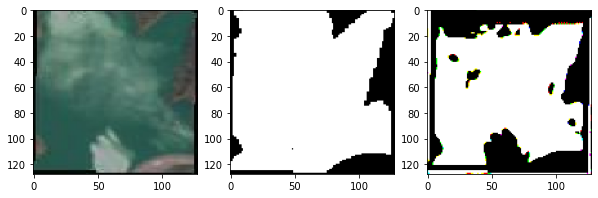

In [181]:
n = 1
examples = test_dataset.take(n)
i, m, p = None, None, None

threshold = 0.5

for (image, mask) in examples:
    i = image
    m = mask
    p_raw = model.predict(image)
    p = p_raw[0]
    p = tf.where(p>threshold, 255, 0)
    print("Raw Prediction ",p_raw.shape)
    p_gray = tf.image.rgb_to_grayscale(p_raw)
    print("GrayScale ",p_gray.shape)
    p_zero = p_gray[0]
    print("0th ",p_zero.shape)
    p_2D = tf.reshape(p_zero, [p_zero.shape[0], p_zero.shape[1]])
    print("2D ",p_2D.shape)
    
    

fig, axs = plt.subplots(1, 3, figsize = (10, 5*n))
axs[0].imshow(i[0])
axs[1].imshow(m[0])
axs[2].imshow(p)

# Evaluating Performance

In [184]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true[0], prediction)
print(meanIoU.result().numpy())

0.609984
